In [1]:
"""
Based on the tflearn CIFAR-10 example at:
https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_cifar10.py
"""

from __future__ import division, print_function, absolute_import

from skimage import color, io
from scipy.misc import imresize
import numpy as np
from sklearn.cross_validation import train_test_split
import os
from glob import glob

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

###################################
### Import picture files 
###################################

files_path = 'rawdata/train/'

cat_files_path = os.path.join(files_path, 'cat*.jpg')
dog_files_path = os.path.join(files_path, 'dog*.jpg')

print (os.path.abspath(cat_files_path))
cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

n_files = len(cat_files) + len(dog_files)
print(n_files)

size_image = 64

allX = np.zeros((n_files, size_image, size_image, 3), dtype='float64')
ally = np.zeros(n_files)
count = 0
for f in cat_files:
    try:
        img = io.imread(f)
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 0
        count += 1
    except:
        continue

for f in dog_files:
    try:
        img = io.imread(f)
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 1
        count += 1
    except:
        continue
   
###################################
# Prepare train & test samples
###################################

# test-train split   
X, X_test, Y, Y_test = train_test_split(allX, ally, test_size=0.1, random_state=42)

# encode the Ys
Y = to_categorical(Y, 2)
Y_test = to_categorical(Y_test, 2)


###################################
# Image transformations
###################################

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

###################################
# Define network architecture
###################################

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# Model Architecture
network = input_data(shape=[None, 224, 224, 1])
conv_1 = relu(conv_2d(network, 64, 7, strides=2, bias=True, padding=padding, activation=None, name='Conv2d_1'))
maxpool_1 = batch_normalization(max_pool_2d(conv_1, 3, strides=2, padding=padding, name='MaxPool_1'))
#LRN_1 = local_response_normalization(maxpool_1, name='LRN_1')
# FeatEX-1
conv_2a = relu(conv_2d(maxpool_1, 96, 1, strides=1, padding=padding, name='Conv_2a_FX1'))
maxpool_2a = max_pool_2d(maxpool_1, 3, strides=1, padding=padding, name='MaxPool_2a_FX1')
conv_2b = relu(conv_2d(conv_2a, 208, 3, strides=1, padding=padding, name='Conv_2b_FX1'))
conv_2c = relu(conv_2d(maxpool_2a, 64, 1, strides=1, padding=padding, name='Conv_2c_FX1'))
FX1_out = merge([conv_2b, conv_2c], mode='concat', axis=3, name='FX1_out')
# FeatEX-2
conv_3a = relu(conv_2d(FX1_out, 96, 1, strides=1, padding=padding, name='Conv_3a_FX2'))
maxpool_3a = max_pool_2d(FX1_out, 3, strides=1, padding=padding, name='MaxPool_3a_FX2')
conv_3b = relu(conv_2d(conv_3a, 208, 3, strides=1, padding=padding, name='Conv_3b_FX2'))
conv_3c = relu(conv_2d(maxpool_3a, 64, 1, strides=1, padding=padding, name='Conv_3c_FX2'))
FX2_out = merge([conv_3b, conv_3c], mode='concat', axis=3, name='FX2_out')
net = flatten(FX2_out)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

###################################
# Train model for 100 epochs
###################################
model.fit(X, Y, validation_set=(X_test, Y_test), batch_size=500,
      n_epoch=100, run_id='model_cat_dog_6', show_metric=True)

model.save('model_cat_dog_6_final.tflearn')

C:\Users\JeanBV\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\JeanBV\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
C:\Users\JeanBV\Documents\TFLearn_2\TFLearn\rawdata\train\cat*.jpg
202


C:\Users\JeanBV\Miniconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\JeanBV\Miniconda3\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
---------------------------------
Run id: model_cat_dog_6
Log directory: tmp/tflearn_logs/
---------------------------------
Preprocessing... Calculating mean over all dataset (this may take long)...
Mean: 112.81444952808471 (To avoid repetitive computation, add it to argument 'mean' of `add_featurewise_zero_center`)
---------------------------------
Preprocessing... Calculating std over all dataset (this may take long)...
STD: 63.13903045440199 (To avoid repetitive computation, add it to argument 'std' of `add_featurewise_stdnorm`)
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 181
Validation samples: 21
--
Training Step: 1  | time: 14.571s
| Adam | epoch: 001 | loss: 0.00000 - Accuracy: 0.0000 | v

KeyboardInterrupt: 

<h1> Test </h1>

In [5]:
# Residual blocks
# 32 layers: n=5, 56 layers: n=9, 110 layers: n=18
n = 5
batch_size = 1000
num_classes = 10
epochs_shortrun = 5
epochs_longrun = 10 #200
save_dir = "/files"
res_dir = "/results"
model_name = 'resnet_cifar10'

In [6]:
from __future__ import division, print_function, absolute_import
import tflearn
from tflearn.datasets import cifar10
import tensorflow as tf

import os, sys, tarfile, glob, shutil
import dill as pickle
import numpy as np

# set random seeds for reproducibility
tf.reset_default_graph()
tflearn.init_graph(seed=343)
tf.set_random_seed(343)
np.random.seed(343)

# makes Tensorflow shush about SSE and such
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Data loading
(X, Y), (testX, testY) = cifar10.load_data(dirname="cifar")
Y = tflearn.data_utils.to_categorical(Y, num_classes)
testY = tflearn.data_utils.to_categorical(testY, num_classes)

save_fn = model_name + ".tfsave"
save_file = os.path.join(save_dir, save_fn)

ckpt_dir = os.path.join(save_dir,"checkpoints")
if not os.path.isdir(ckpt_dir):
    os.makedirs(ckpt_dir)

tblog_dir = os.path.join(save_dir,"tflogs")
if not os.path.isdir(tblog_dir):
    os.makedirs(tblog_dir)
event_dir = os.path.join(tblog_dir,model_name)

# Function to find latest checkpoint file
def last_ckpt(dir):
  fl = os.listdir(dir)
  fl = [x for x in fl if x.endswith(".index")]
  cf = ""
  if len(fl) > 0:
    steps = [float(x.split("-")[1][0:-6]) for x in fl]
    m = max(steps)
    cf = fl[steps.index(m)]
    cf = os.path.join(dir,cf)
  
  return(cf)

import matplotlib.pyplot as plt
from math import *

with open("/cifar/cifar-10-batches-py/batches.meta", 'rb') as fo:
    labels = pickle.load(fo)

#Visualizing CIFAR 10, takes indicides and shows in a grid
def cifar_grid(Xset,Yset,inds,n_col, predictions=None):
  if predictions is not None:
    if Yset.shape != predictions.shape:
      print("Predictions must equal Yset in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
  clabels = labels["label_names"]
  for j in range(n_row):
    for k in range(n_col):
      i_inds = j*n_col+k
      i_data = inds[i_inds]
      
      axes[j][k].set_axis_off()
      if i_inds < N:
        axes[j][k].imshow(Xset[i_data,...], interpolation='nearest')
        label = clabels[np.argmax(Yset[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)
  return(fig)

# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
img_prep.add_featurewise_zero_center(per_channel=True, 
    mean=[ 0.49139968, 0.48215841, 0.44653091 ])

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_crop([32, 32], padding=4)

C:\Users\JeanBV\Miniconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


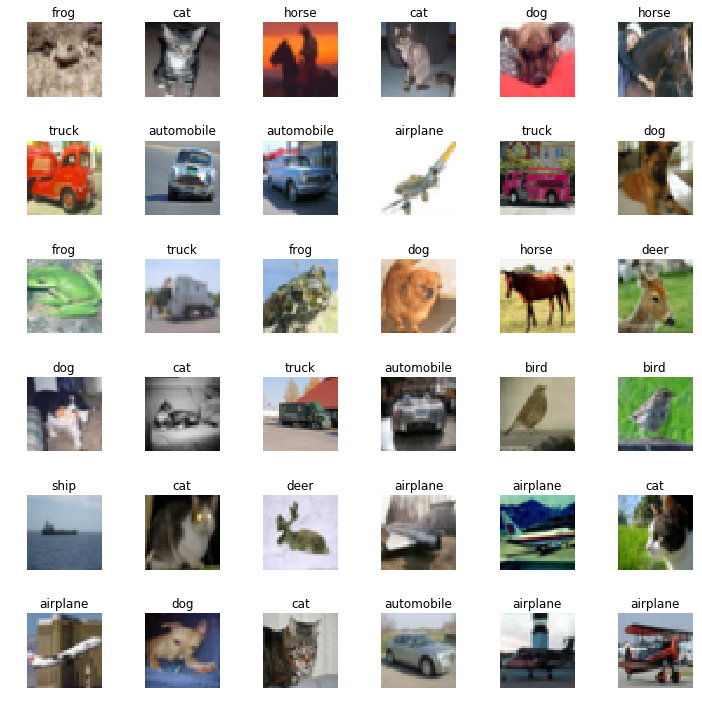

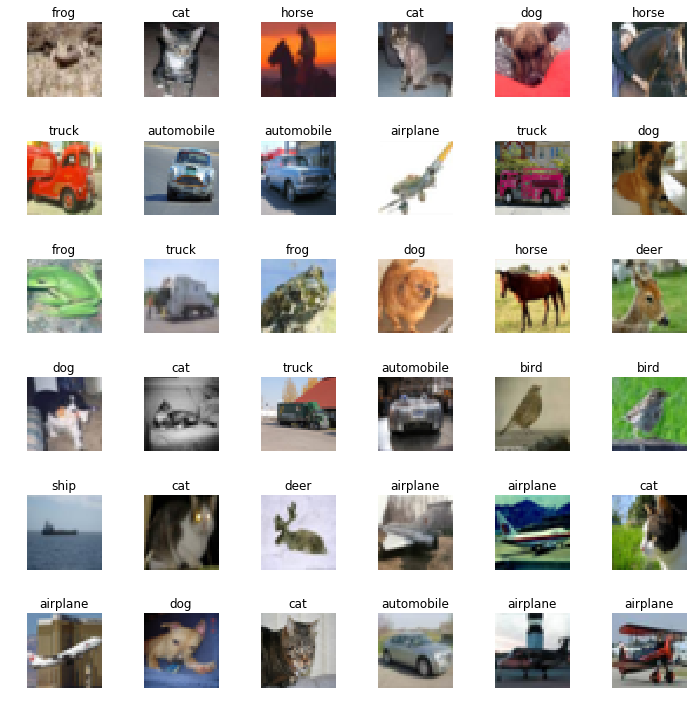

In [7]:
indices = [np.random.choice(range(len(X))) for i in range(36)]

cifar_grid(X,Y,indices,6)

In [8]:
# Building Residual Network
net = tflearn.input_data(shape=[None, 32, 32, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
net = tflearn.conv_2d(net, 16, 3, regularizer='L2', weight_decay=0.0001)
net = tflearn.residual_block(net, n, 16)
net = tflearn.residual_block(net, 1, 32, downsample=True)
net = tflearn.residual_block(net, n-1, 32)
........................................
net = tflearn.residual_block(net, 1, 64, downsample=True)
net = tflearn.residual_block(net, n-1, 64)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

# Regression
net = tflearn.fully_connected(net, num_classes, activation='softmax')
mom = tflearn.Momentum(0.1, lr_decay=0.1, decay_step=32000, staircase=True)
net = tflearn.regression(net, optimizer=mom,
                         loss='categorical_crossentropy')

# define the early-stop callback
class EarlyStoppingCallback(tflearn.callbacks.Callback):
    def __init__(self, val_loss_thresh, val_loss_patience):
        """ minimum loss improvement setup """
        self.val_loss_thresh = val_loss_thresh
        self.val_loss_last = float('inf')
        self.val_loss_patience = val_loss_patience
        self.val_loss_squint = 0
    
    def on_batch_end(self, training_state, snapshot=False):
        """ loss improvement threshold w/ patience """
        # Apparently this can happen.
        if training_state.val_loss is None: return
        
        if (self.val_loss_last - training_state.val_loss) < self.val_loss_thresh:
          # unacceptable!
          if self.val_loss_squint >= self.val_loss_patience:
            raise StopIteration
          else:
            self.val_loss_squint += 1
        else:
          # we good again - reset
          self.val_loss_last = training_state.val_loss
          self.val_loss_squint = 0
          
# Initialize model
ckpt_file = os.path.join(ckpt_dir,"model.ckpt")
model = tflearn.DNN(net, checkpoint_path=ckpt_file,
                    max_checkpoints=10, clip_gradients=0.,
                    tensorboard_dir=tblog_dir,tensorboard_verbose=0)

# disabled until directories can be written to /results
#cff = last_ckpt(ckpt_dir)
#if cff != "":
#  print("Loading ",cff,"...")
#  model.load(cff)

# Initializae our callback.
early_stopping_cb = EarlyStoppingCallback(
  val_loss_thresh=0.001, val_loss_patience=25)

In [9]:
print("Starting to train...")

# checkpoints disabled until directories can be written to /results
try:
  model.fit(X, Y, n_epoch=epochs_longrun, validation_set=(testX, testY),
     snapshot_epoch=True, snapshot_step=None,
     show_metric=True, batch_size=batch_size, shuffle=True,
     run_id='resnet_cifar10',
     callbacks=early_stopping_cb)
except StopIteration:
    print("Got bored, stopping early.")

print("Training complete.")

model.save(save_file)

# can only save single files to /results, so let's tar the saves
tar_file = os.path.join(res_dir,model_name)+".tar.bz2"
with tarfile.open(tar_file, "w:bz2") as tar:
  for name in [x for x in os.listdir(save_dir) 
               if x.startswith(save_fn)]:
    tar.add(os.path.join(save_dir, name), arcname=name)

# copy events file to /results for history plotting
evfiles = filter(os.path.isfile, glob.glob(os.path.join(event_dir, 
                                           "events.out.tfevents.*")))
evfiles.sort(key=lambda x: os.path.getmtime(x))
shutil.copyfile(os.path.join(event_dir,evfiles[-1]),
                os.path.join(res_dir,model_name+".tfevents"))

Starting to train...
---------------------------------
Run id: resnet_cifar10
Log directory: /files\tflogs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 50000
Validation samples: 10000
--


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tflearn\helpers\trainer.py", line 347, in fit
    self.session.run(self.incr_global_step)
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tensorflow\python\client\session.py", line 895, in run
    run_metadata_ptr)
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tensorflow\python\client\session.py", line 1113, in _run
    self._graph, fetches, feed_dict_tensor, feed_handles=feed_handles)
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tensorflow\python\client\session.py", line 420, in __init__
    self._fetch_mapper = _FetchMapper.for_fetch(fetches)
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tensorflow\python\client\session.py", line 248, in for_fetch
    return _ElementFetchMapper(fetches, contraction_fn)
  File "C:\Users\JeanBV\Miniconda3\lib\site-packages\tensorflow\python\client\session.py", line 276, in __init__
    self._unique_fetches.append(ops.get_default_graph().as

TypeError: must be str, not list

In [ ]:
import numpy as np
import tflearn
import tflearn.activations as activations
# Data loading and preprocessing
from tflearn.activations import relu
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.conv import avg_pool_2d, conv_2d, max_pool_2d
from tflearn.layers.core import dropout, flatten, fully_connected, input_data
from tflearn.layers.merge_ops import merge
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.normalization import batch_normalization

# Give a run ID here. Change it to flags (arguments) in version 2.
ID = '4_1'
RUNID = 'DeXpression_run_' + ID

# Give a dropout if required (change to True and define the dropout percentage).
dropout = False
dropout_keep_prob=0.5

# Load data
X = np.load('CKP_X.npy')
Y = np.load('CKP_Y.npy')

# Define number of output classes.
num_classes = 7

# Define padding scheme.
padding = 'VALID'b

# Model Architecture
network = input_data(shape=[None, 224, 224, 1])
conv_1 = relu(conv_2d(network, 64, 7, strides=2, bias=True, padding=padding, activation=None, name='Conv2d_1'))
maxpool_1 = batch_normalization(max_pool_2d(conv_1, 3, strides=2, padding=padding, name='MaxPool_1'))
#LRN_1 = local_response_normalization(maxpool_1, name='LRN_1')
# FeatEX-1
conv_2a = relu(conv_2d(maxpool_1, 96, 1, strides=1, padding=padding, name='Conv_2a_FX1'))
maxpool_2a = max_pool_2d(maxpool_1, 3, strides=1, padding=padding, name='MaxPool_2a_FX1')
conv_2b = relu(conv_2d(conv_2a, 208, 3, strides=1, padding=padding, name='Conv_2b_FX1'))
conv_2c = relu(conv_2d(maxpool_2a, 64, 1, strides=1, padding=padding, name='Conv_2c_FX1'))
FX1_out = merge([conv_2b, conv_2c], mode='concat', axis=3, name='FX1_out')
# FeatEX-2
conv_3a = relu(conv_2d(FX1_out, 96, 1, strides=1, padding=padding, name='Conv_3a_FX2'))
maxpool_3a = max_pool_2d(FX1_out, 3, strides=1, padding=padding, name='MaxPool_3a_FX2')
conv_3b = relu(conv_2d(conv_3a, 208, 3, strides=1, padding=padding, name='Conv_3b_FX2'))
conv_3c = relu(conv_2d(maxpool_3a, 64, 1, strides=1, padding=padding, name='Conv_3c_FX2'))
FX2_out = merge([conv_3b, conv_3c], mode='concat', axis=3, name='FX2_out')
net = flatten(FX2_out)
if dropout:
    net = dropout(net, dropout_keep_prob)
loss = fully_connected(net, num_classes,activation='softmax')

# Compile the model and define the hyperparameters
network = tflearn.regression(loss, optimizer='Adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0001)

# Final definition of model checkpoints and other configurations
model = tflearn.DNN(network, checkpoint_path='/home/cc/DeXpression/DeXpression_checkpoints',
                    max_checkpoints=1, tensorboard_verbose=2, tensorboard_dir="./tflearn_logs/")

# Fit the model, train for 20 epochs. (Change all parameters to flags (arguments) on version 2.)
model.fit(X, Y, n_epoch=20, validation_set=0.1, shuffle=True, show_metric=True, batch_size=350, snapshot_step=2000,snapshot_epoch=True, run_id=RUNID)

# Save the model
model.save('./DeXpression_checkpoints/' + RUNID + '.model')

# Load the model if required, later.
#model.load('./DeXpression_checkpoints/' + RUNID + '.model')